In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras import layers
from keras import models

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

Using TensorFlow backend.
/home/rk/dev/env/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## 데이터 살펴보기 

- 국제선 이용고객 수(단위 천명)

In [7]:
filename = 'data/international-airline-passengers.csv'
df = pd.read_csv(filename, usecols=[1])

df.head(3)

,International
0,112
1,118
2,132


In [8]:
df['International'].dtype

dtype('int64')

In [12]:
df.sample(5)

,International
35,166
59,201
81,274
42,230
21,133


In [9]:
df.tail()

,International
139,606
140,508
141,461
142,390
143,432


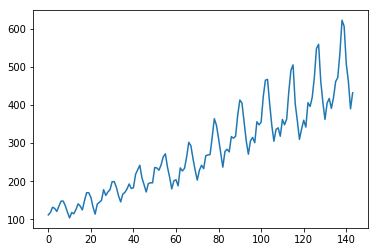

In [8]:
def plot_csv(df):
    plt.plot(df.values)
    plt.show()
    
plot_csv(df)

## 데이터를 정규화해서 저장하는 클래스 만들기 

In [13]:
class Dataset:
    def __init__(self, filename, look_ahead):
        df = pd.read_csv(filename, usecols=[1])
        data = df.values.reshape(-1, 1).astype('float32')
        data = MinMaxScaler().fit_transform(data)
        
        self.X, self.Y = self.generate_XY(data, look_ahead)
        
        self.train_X, self.test_X, self.train_Y, self.test_Y = \
            train_test_split(self.X, self.Y, test_size=0.2, random_state=137)
        
    def generate_XY(self, data, look_ahead):
        xs, ys = [], []
        for i in range(len(data)-1-look_ahead):
            xs.append(data[i:i+look_ahead])
            ys.append(data[i+look_ahead])
        X = np.array(xs)
        X = X.reshape(X.shape[0], X.shape[1], 1)
        Y = np.array(ys)
        return X, Y

In [20]:
dataset = Dataset(filename, 10)

In [21]:
dataset.X.shape

(133, 10, 1)

In [22]:
dataset.X[0]

array([[ 0.01544401],
       [ 0.02702703],
       [ 0.05405405],
       [ 0.04826255],
       [ 0.03281853],
       [ 0.05984557],
       [ 0.08494207],
       [ 0.08494207],
       [ 0.06177607],
       [ 0.02895753]], dtype=float32)

## LSTM 모델 만들기 

- LSTM 설명 변역글 : https://brunch.co.kr/@chris-song/9

In [23]:
def lstm_model(input_shape):
    m_x = layers.Input(shape=input_shape)
    m_h = layers.LSTM(10)(m_x)
    m_y = layers.Dense(1)(m_h)
    model  = models.Model(m_x, m_y)
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    return model

In [24]:
lstm_model((1,1))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 1)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


## LSTM 클래스 만들기

In [29]:
class LSTMMachine:
    def __init__(self, look_ahead):
        self.data = Dataset(filename, look_ahead)
        input_shape = self.data.X.shape[1:]
        self.model  = self.lstm_model(input_shape)
    
    def run(self, epochs=500):
        d = self.data
        X, Y = d.X, d.Y
        train_X, train_Y = d.train_X, d.train_Y
        test_X, test_Y = d.test_X, d.test_Y
        
        history = self.model.fit(train_X, train_Y, epochs=epochs,
                                    validation_data=[test_X, test_Y], verbose=0)
        predicted_Y = self.model.predict(test_X)
        plot_loss(history)
        
        plt.plot(predicted_Y, label='Original')
        plt.plot(test_Y, label='Prediction')
        plt.legend(loc=0)
        plt.title('Validation Results')
        plt.show()
        
        df = pd.DataFrame()
        df['Sample'] = list(range(len(test_Y))) * 2
        df['Normalized'] = np.concatenate([test_Y, predicted_Y], axis=0)
        df['Type'] = ['Original'] * len(test_Y) + ['Prediction'] * len(predicted_Y)
        
        plt.figure(figsize=(7, 5))
        sns.barplot(x='Sample', y='Normalized', hue='Type', data=df)
        plt.show()
        
        predicted_Y_all = self.model.predict(X)
        
        plt.plot(predicted_Y_all, label='Prediction')
        plt.plot(Y, label='Original')
        plt.legend(loc=0)
        plt.show()
        
        
    def lstm_model(self, input_shape):
        m_x = layers.Input(shape=input_shape)
        m_h = layers.LSTM(20)(m_x)
        m_y = layers.Dense(1)(m_h)
        model  = models.Model(m_x, m_y)
        model.compile(loss='mean_squared_error', optimizer='adam')
        return model
    
    
    
def plot_acc(history, title=None):
    if not isinstance(history, dict):
        history = history.history
        
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    
    if title is not None:
        plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Traning data', 'Validation data'], loc=0)
    plt.show()
    
def plot_loss(history, title=None):
    if not isinstance(history, dict):
        history = history.history
        
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    
    if title is not None:
        plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Traning data', 'Validation data'], loc=0)
    plt.show()

## 실행 

In [31]:
def main():
    machine = LSTMMachine(5)
    machine.run(epochs=300)

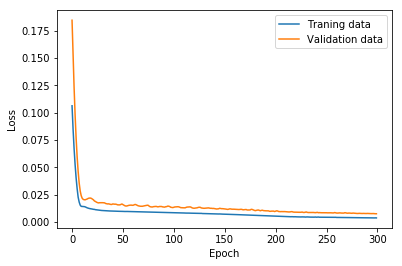

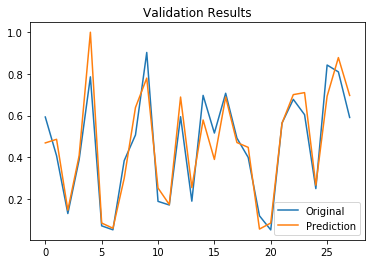

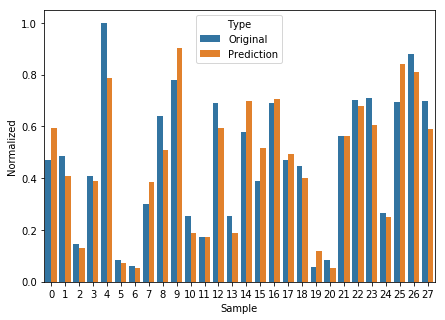

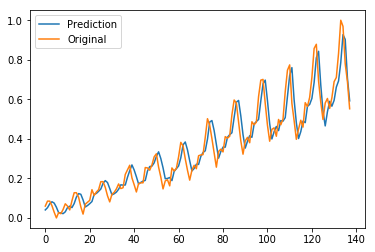

In [32]:
main()